In [1]:
import math
import random
#Benötigte Pakete

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import seaborn as sns
from scipy import stats
from decimal import Decimal

import matplotlib.mlab as mlab
import numpy as np
import cmath

from numpy import linalg as LA
import scipy
from scipy import spatial
import time
#import tables

import os
#import h5py

from matplotlib import animation
import matplotlib
from scipy.optimize import curve_fit
from matplotlib import rc

import gc
import sys
gc.enable()
import copy

from mpl_toolkits import mplot3d

from scipy.odr import *

### Eingabe

In [3]:
number_atoms=5               # anzahl atome
a = 100                      # fläche für erzeugte atome  a->x achse
r_b = 5                      # constraint rydberg blockade
coupling_constant= 3*10**9   # stärke der nachbarwechselwirkung


def poly_func(a,N):
    return a[0]*N**a[1]

def poly_func_scipy(N,*a):
    return a[0]*N**a[1]

### Erzeugung

In the following function "produce_atoms" the arrangement of the atoms will be produced completely randomly:
Parameters are number of the atoms, the radius of the plain, Rydberg blockade and a 2D array "vorher", which could be a previous arrangement. If we don't need a previous arrangement, we hand over an empty array.

In the functions hexagonal and square a lattice is produced, either hexagonal (densest packing) or square.

In [4]:
def produce_atoms(number_atoms, a, r_b, vorher):
    A=np.pi*a*a
   
    if len(vorher)==0:
        atoms = [[0,0]]
    else: 
        atoms = np.ndarray.tolist(vorher)

        
    for i in range(number_atoms-len(atoms)):
        j=0
        r=a*np.sqrt(random.uniform(0,1))
        theta=random.uniform(0,1)*2*np.pi
        x,y=r * np.cos(theta), r * np.sin(theta)
        punkt = np.array([[x,y]]) 
        gesetzt= False
        while (gesetzt==False):
            gesetzt=True
            if ((np.min(scipy.spatial.distance.cdist(atoms, punkt, metric='euclidean')))<(2*r_b)):
                r=a*np.sqrt(random.uniform(0,1))
                theta=random.uniform(0,1)*2*np.pi
                x,y=r * np.cos(theta), r * np.sin(theta)
                punkt = np.array([[x,y]]) 
                gesetzt=False
            
        atoms.append([punkt[0][0],punkt[0][1]])

    return np.round(atoms,4)

### Hamiltonian

In the following we calculate the distances for each pair of atoms and calculate the Hamiltonian withit.

In [5]:
def generate_hamiltonian(atoms):
    number_atoms=len(atoms)
    
    #Distance + Hamiltonian-------------------------------------------------------------------------------------
    H = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    global distance_matrix
    distance_matrix = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    
    
    #start= time.time()
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    #print("Time for Hamiltonian: ",time.time()-start)
    
    
    global abstand_ursprung
    abstand_ursprung= np.zeros(number_atoms, dtype=np.float16)
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    
#Linearisierung---------------------------------------------------------------------------------------------
    #start = time.time()
    global eigenvalues
    global eigenvectors
    
    eigenvalues=np.zeros(number_atoms,dtype=np.float16)
    eigenvectors=np.zeros((number_atoms,number_atoms),dtype=np.float16)
    
    eigenvalues, eigenvectors = LA.eigh(H)
  
    #print("Time for Linearisierung: ",time.time()-start)
    
    return 

### Evaluation - Eigenstates

The function one_eigenstate calculates properties like the radial density for a given eigenstate.
The function participation ratio caluclates properties for the whole system, Participation ratio or level statistics.

In [6]:
def one_eigenstate(eigenstate,dr_corr):
   
    #eigenstate----------------------------------------------------------------------------------------
    
    p_eigenstate =  np.square(np.absolute(eigenvectors[:,eigenstate]))
  
    
    #schwerpunkt------------------------------------------------------------------------------------------
    schwerpunkt= np.dot(p_eigenstate,atoms_array) 
    distanz= scipy.spatial.distance.cdist([schwerpunkt],atoms_array, metric='euclidean')[0]
 
    #correlation
    #radial density from Schwerpunkt aus des eigenstates ------------------------------------------------
    
    correlation=[]
    density_eig=[]
    
    for klein in range(0,int(max_abstand),dr_corr):     
        index = np.argwhere((klein<=distanz) & (distanz<klein+d_r))
        laenge= len(index)
        
        if laenge==0:
            density_eig.append(0)
        else:
            density_eig.append(np.sum(p_eigenstate[index])/len(index))
   
 
    return p_eigenstate, density_eig,


def calc_ipr():

    p_eigenstates = np.square(np.absolute(eigenvectors))  
   
    #inverse participation ratio ------------------------------------------------------------------------
    ipr_2=[]
    for i in range(number_atoms):    
        ipr_2.append(np.sum(p_eigenstates[:,i]**2)) 
    
    
    ratio = np.zeros([number_atoms])
    for n in range(1,number_atoms-1):
        delta_n = eigenvalues[n+1]-eigenvalues[n]
        delta_n_1 = eigenvalues[n]-eigenvalues[n-1]
        ratio[n] = np.min([delta_n,delta_n_1])/np.max([delta_n,delta_n_1])
        
    return ipr_2,ratio

# Plotting

### Plots for the eigenstates 

plot_one_eigenstate shows characteristics of a special eigenstate
plot_all_eigenstates shows properties of the whole system, like Participation ratios oder level statistics.

In [7]:
def plot_one_eigenstate(p_eigenstate, density_eig, schwerpunkt, dr_corr):
    
    # 3d and 2d scatter animation plot ------------------------------------------------------------------
    
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(2, 2, 1)
    ax.set_aspect('equal')
    
    scat= ax.scatter(atoms_array[:,0], atoms_array[:,1], marker='o', c=p_eigenstate, cmap = "jet",
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1*10**0))
    
    plt.colorbar(scat, label="probability", ax=ax)
    ax.plot(schwerpunkt[0],schwerpunkt[1],"x",markersize=15,markeredgewidth=2, markerfacecolor="red",markeredgecolor="red")
    
    
    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.plot_trisurf(atoms_array[:,0], atoms_array[:,1], p_eigenstate, cmap='jet', linewidth=0.5,
                    norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))
   

    ax = fig.add_subplot(2, 2, 3)
    ax.set_aspect('equal')
    
    indices= np.squeeze(scipy.spatial.distance.cdist([schwerpunkt],atoms_array, metric='euclidean')<radius*0.3)
    atoms_close= atoms_array[indices]
    scat2= ax.scatter(atoms_close[:,0], atoms_close[:,1], marker='o',c=p_eigenstate[indices], cmap = "jet",
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1*10**0))
   
    for i in range(len(atoms_close)):
        circle = plt.Circle((atoms_close[i][0], atoms_close[i][1]), radius=r_b, fill=False)
        plt.gca().add_patch(circle)
  
    

    plt.show()

    #----------------------------------------------------------------------------------------------------

    
    fig, axes = plt.subplots(2,2,figsize=(13,8))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
     
    
    axes[1,0].set_title("radial density - single log")
    axes[1,0].plot(x1,density_eig)
    axes[1,0].set_yscale("log")
    
    axes[1,1].set_title("radial density - double log")
    axes[1,1].plot(x1,density_eig)
    axes[1,1].set_xscale("log")
    axes[1,1].set_yscale("log")
    
    axes[1,1].plot(x,poly_func(x,10000,-6)) 

In [8]:
def plot_all_eigenstates(pr_2,ratio):

    
    
    x=np.arange(0,radius,1)   
    
    fig, axes = plt.subplots(3,2,figsize=(13,8))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2)
    

   
    axes[0,0].set_title("Level Spectrum")
    bins = np.linspace(min(eigenvalues),max(eigenvalues),50)
    axes[0,0].hist(eigenvalues,bins=bins)
    axes[0,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    
    
    hist, bin_edges = np.histogram(ratio, bins=500)
    axes[0,1].step(bin_edges[:-1],hist,where="post");
    axes[0,1].set_title("Häufigkeit der level spacing ratios")
        
    
    states=np.arange(0,number_atoms,1)
    axes[1,0].set_title("Participation Ratio - über Energie")
    axes[1,0].errorbar(eigenvalues,pr_2, linestyle="None", marker=".") ;   
    #axes[1,0].set_yscale("log")
    axes[1,0].set_xlabel("energy")
    axes[1,0].set_ylabel("PR")
    axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
          
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    pr_2, statistic='mean', bins=50)
    bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    pr_2, statistic='std', bins=50)
    
    
    axes[1,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
    axes[1,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
               label='binned statistic of data')
    axes[1,1].set_title("Participation ratio - gebint")
    axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    
    

    axes[2,0].set_title("ratios - über Energie")
    axes[2,0].errorbar(eigenvalues,ratio, linestyle="None", marker=".") ;   
    #axes[1,0].set_yscale("log")
    axes[2,0].set_xlabel("energy")
    axes[2,0].set_ylabel("ratios")
    axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    ratio, statistic='mean', bins=50)
    bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues,
                    ratio, statistic='std', bins=50)

    
    axes[2,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
    axes[2,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
               label='binned statistic of data') 
    axes[2,1].set_title("averaged level spacing ratios")
    
    

    fig.tight_layout()

# Mean Execution

In [24]:
global number_atoms
global radius
coupling_constant= 3*10**9  #stärke der nachbarwechselwirkung

#Parameter:
number_atoms=100
density= 0.2
r_b = 5
radius = (np.sqrt(number_atoms*r_b**2/density))


global angeregt
angeregt=0                  #atom 0 is atom in the center


z= pow(number_atoms/(np.pi*radius*radius), -1.0/2.0)
print("Radius of the plain: ", round(radius,2))
print("Rydberg Blockade:", round(r_b*2,2))
print("Dichte: ", np.round((number_atoms*np.pi*r_b*r_b)/(np.pi*radius**2),2))
print("Mittlerer abstand:", round(z,2))
print()


anzahl = np.array([1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50])*number_atoms
radiusse = (np.sqrt(anzahl*r_b**2/density))
#iteration= (200000/anzahl).astype(int)
iteration= [5000,3000,1000,500,400,333,285,250,222,200,60,60,50,50,40,25,25,20]*2

Radius of the plain:  111.8
Rydberg Blockade: 10
Dichte:  0.2
Mittlerer abstand: 19.82



In [25]:
print("anzahl", anzahl)
print("iterationen", iteration)
print("radius", np.round(radiusse,2))
print("dichte", anzahl*r_b**2/radiusse**2)

anzahl [ 100  200  300  400  500  600  700  800  900 1000 1500 2000 2500 3000
 3500 4000 4500 5000]
iterationen [5000, 3000, 1000, 500, 400, 333, 285, 250, 222, 200, 60, 60, 50, 50, 40, 25, 25, 20, 5000, 3000, 1000, 500, 400, 333, 285, 250, 222, 200, 60, 60, 50, 50, 40, 25, 25, 20]
radius [111.8  158.11 193.65 223.61 250.   273.86 295.8  316.23 335.41 353.55
 433.01 500.   559.02 612.37 661.44 707.11 750.   790.57]
dichte [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]


Im Folgenden ist die Schleife für verschiedene Systemgrößen bei gleichbleibender Dichte.

In [26]:
save_nr=0
z=0

start1=time.time()
gebrauchte_zeit=np.zeros(len(anzahl))

for number_atoms, radius in zip(anzahl,radiusse):  
    print(number_atoms)
    print()
    start2=time.time()
        
        
    atoms_array = produce_atoms(number_atoms, radius, r_b,[])
                  
    generate_hamiltonian(atoms_array)
    
    ipr_2_all, ratio_all = calc_ipr()
    eigenvalues_all= eigenvalues
    

    save_nr+=1
    for i in range(0,iteration[z]-1):
    
        print("Iteration:", i+1)
        
        atoms_array = produce_atoms(number_atoms, radius, r_b,[])
        
        generate_hamiltonian(atoms_array)
       
    
        ipr_2_tmp, ratio_tmp = calc_ipr()
        
        
        ratio_all                       =  np.concatenate((ratio_all,ratio_tmp))
        eigenvalues_all                 =  np.concatenate((eigenvalues_all,eigenvalues))
        ipr_2_all                       =  np.concatenate((ipr_2_all,ipr_2_tmp))
    
        save_nr+=1
        
    gebrauchte_zeit[z]=(time.time()-start2)
    print(gebrauchte_zeit[z])
    z+=1


    data = open("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/test_files/fractality/density_"+str(np.round(density,3))+"/"+str(number_atoms)+"_"+str(int(radius))+".npy","wb")
    
    np.save(data,ipr_2_all)   
    np.save(data,ratio_all)                       
    np.save(data,eigenvalues_all)                 
  
   
    data.close()
    
    
print(gebrauchte_zeit)
print(time.time()-start1)

100

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration:

Iteration: 560
Iteration: 561
Iteration: 562
Iteration: 563
Iteration: 564
Iteration: 565
Iteration: 566
Iteration: 567
Iteration: 568
Iteration: 569
Iteration: 570
Iteration: 571
Iteration: 572
Iteration: 573
Iteration: 574
Iteration: 575
Iteration: 576
Iteration: 577
Iteration: 578
Iteration: 579
Iteration: 580
Iteration: 581
Iteration: 582
Iteration: 583
Iteration: 584
Iteration: 585
Iteration: 586
Iteration: 587
Iteration: 588
Iteration: 589
Iteration: 590
Iteration: 591
Iteration: 592
Iteration: 593
Iteration: 594
Iteration: 595
Iteration: 596
Iteration: 597
Iteration: 598
Iteration: 599
Iteration: 600
Iteration: 601
Iteration: 602
Iteration: 603
Iteration: 604
Iteration: 605
Iteration: 606
Iteration: 607
Iteration: 608
Iteration: 609
Iteration: 610
Iteration: 611
Iteration: 612
Iteration: 613
Iteration: 614
Iteration: 615
Iteration: 616
Iteration: 617
Iteration: 618
Iteration: 619
Iteration: 620
Iteration: 621
Iteration: 622
Iteration: 623
Iteration: 624
Iteration: 625
Iteration:

Iteration: 1104
Iteration: 1105
Iteration: 1106
Iteration: 1107
Iteration: 1108
Iteration: 1109
Iteration: 1110
Iteration: 1111
Iteration: 1112
Iteration: 1113
Iteration: 1114
Iteration: 1115
Iteration: 1116
Iteration: 1117
Iteration: 1118
Iteration: 1119
Iteration: 1120
Iteration: 1121
Iteration: 1122
Iteration: 1123
Iteration: 1124
Iteration: 1125
Iteration: 1126
Iteration: 1127
Iteration: 1128
Iteration: 1129
Iteration: 1130
Iteration: 1131
Iteration: 1132
Iteration: 1133
Iteration: 1134
Iteration: 1135
Iteration: 1136
Iteration: 1137
Iteration: 1138
Iteration: 1139
Iteration: 1140
Iteration: 1141
Iteration: 1142
Iteration: 1143
Iteration: 1144
Iteration: 1145
Iteration: 1146
Iteration: 1147
Iteration: 1148
Iteration: 1149
Iteration: 1150
Iteration: 1151
Iteration: 1152
Iteration: 1153
Iteration: 1154
Iteration: 1155
Iteration: 1156
Iteration: 1157
Iteration: 1158
Iteration: 1159
Iteration: 1160
Iteration: 1161
Iteration: 1162
Iteration: 1163
Iteration: 1164
Iteration: 1165
Iteratio

Iteration: 1620
Iteration: 1621
Iteration: 1622
Iteration: 1623
Iteration: 1624
Iteration: 1625
Iteration: 1626
Iteration: 1627
Iteration: 1628
Iteration: 1629
Iteration: 1630
Iteration: 1631
Iteration: 1632
Iteration: 1633
Iteration: 1634
Iteration: 1635
Iteration: 1636
Iteration: 1637
Iteration: 1638
Iteration: 1639
Iteration: 1640
Iteration: 1641
Iteration: 1642
Iteration: 1643
Iteration: 1644
Iteration: 1645
Iteration: 1646
Iteration: 1647
Iteration: 1648
Iteration: 1649
Iteration: 1650
Iteration: 1651
Iteration: 1652
Iteration: 1653
Iteration: 1654
Iteration: 1655
Iteration: 1656
Iteration: 1657
Iteration: 1658
Iteration: 1659
Iteration: 1660
Iteration: 1661
Iteration: 1662
Iteration: 1663
Iteration: 1664
Iteration: 1665
Iteration: 1666
Iteration: 1667
Iteration: 1668
Iteration: 1669
Iteration: 1670
Iteration: 1671
Iteration: 1672
Iteration: 1673
Iteration: 1674
Iteration: 1675
Iteration: 1676
Iteration: 1677
Iteration: 1678
Iteration: 1679
Iteration: 1680
Iteration: 1681
Iteratio

Iteration: 2138
Iteration: 2139
Iteration: 2140
Iteration: 2141
Iteration: 2142
Iteration: 2143
Iteration: 2144
Iteration: 2145
Iteration: 2146
Iteration: 2147
Iteration: 2148
Iteration: 2149
Iteration: 2150
Iteration: 2151
Iteration: 2152
Iteration: 2153
Iteration: 2154
Iteration: 2155
Iteration: 2156
Iteration: 2157
Iteration: 2158
Iteration: 2159
Iteration: 2160
Iteration: 2161
Iteration: 2162
Iteration: 2163
Iteration: 2164
Iteration: 2165
Iteration: 2166
Iteration: 2167
Iteration: 2168
Iteration: 2169
Iteration: 2170
Iteration: 2171
Iteration: 2172
Iteration: 2173
Iteration: 2174
Iteration: 2175
Iteration: 2176
Iteration: 2177
Iteration: 2178
Iteration: 2179
Iteration: 2180
Iteration: 2181
Iteration: 2182
Iteration: 2183
Iteration: 2184
Iteration: 2185
Iteration: 2186
Iteration: 2187
Iteration: 2188
Iteration: 2189
Iteration: 2190
Iteration: 2191
Iteration: 2192
Iteration: 2193
Iteration: 2194
Iteration: 2195
Iteration: 2196
Iteration: 2197
Iteration: 2198
Iteration: 2199
Iteratio

Iteration: 2654
Iteration: 2655
Iteration: 2656
Iteration: 2657
Iteration: 2658
Iteration: 2659
Iteration: 2660
Iteration: 2661
Iteration: 2662
Iteration: 2663
Iteration: 2664
Iteration: 2665
Iteration: 2666
Iteration: 2667
Iteration: 2668
Iteration: 2669
Iteration: 2670
Iteration: 2671
Iteration: 2672
Iteration: 2673
Iteration: 2674
Iteration: 2675
Iteration: 2676
Iteration: 2677
Iteration: 2678
Iteration: 2679
Iteration: 2680
Iteration: 2681
Iteration: 2682
Iteration: 2683
Iteration: 2684
Iteration: 2685
Iteration: 2686
Iteration: 2687
Iteration: 2688
Iteration: 2689
Iteration: 2690
Iteration: 2691
Iteration: 2692
Iteration: 2693
Iteration: 2694
Iteration: 2695
Iteration: 2696
Iteration: 2697
Iteration: 2698
Iteration: 2699
Iteration: 2700
Iteration: 2701
Iteration: 2702
Iteration: 2703
Iteration: 2704
Iteration: 2705
Iteration: 2706
Iteration: 2707
Iteration: 2708
Iteration: 2709
Iteration: 2710
Iteration: 2711
Iteration: 2712
Iteration: 2713
Iteration: 2714
Iteration: 2715
Iteratio

Iteration: 3170
Iteration: 3171
Iteration: 3172
Iteration: 3173
Iteration: 3174
Iteration: 3175
Iteration: 3176
Iteration: 3177
Iteration: 3178
Iteration: 3179
Iteration: 3180
Iteration: 3181
Iteration: 3182
Iteration: 3183
Iteration: 3184
Iteration: 3185
Iteration: 3186
Iteration: 3187
Iteration: 3188
Iteration: 3189
Iteration: 3190
Iteration: 3191
Iteration: 3192
Iteration: 3193
Iteration: 3194
Iteration: 3195
Iteration: 3196
Iteration: 3197
Iteration: 3198
Iteration: 3199
Iteration: 3200
Iteration: 3201
Iteration: 3202
Iteration: 3203
Iteration: 3204
Iteration: 3205
Iteration: 3206
Iteration: 3207
Iteration: 3208
Iteration: 3209
Iteration: 3210
Iteration: 3211
Iteration: 3212
Iteration: 3213
Iteration: 3214
Iteration: 3215
Iteration: 3216
Iteration: 3217
Iteration: 3218
Iteration: 3219
Iteration: 3220
Iteration: 3221
Iteration: 3222
Iteration: 3223
Iteration: 3224
Iteration: 3225
Iteration: 3226
Iteration: 3227
Iteration: 3228
Iteration: 3229
Iteration: 3230
Iteration: 3231
Iteratio

Iteration: 3687
Iteration: 3688
Iteration: 3689
Iteration: 3690
Iteration: 3691
Iteration: 3692
Iteration: 3693
Iteration: 3694
Iteration: 3695
Iteration: 3696
Iteration: 3697
Iteration: 3698
Iteration: 3699
Iteration: 3700
Iteration: 3701
Iteration: 3702
Iteration: 3703
Iteration: 3704
Iteration: 3705
Iteration: 3706
Iteration: 3707
Iteration: 3708
Iteration: 3709
Iteration: 3710
Iteration: 3711
Iteration: 3712
Iteration: 3713
Iteration: 3714
Iteration: 3715
Iteration: 3716
Iteration: 3717
Iteration: 3718
Iteration: 3719
Iteration: 3720
Iteration: 3721
Iteration: 3722
Iteration: 3723
Iteration: 3724
Iteration: 3725
Iteration: 3726
Iteration: 3727
Iteration: 3728
Iteration: 3729
Iteration: 3730
Iteration: 3731
Iteration: 3732
Iteration: 3733
Iteration: 3734
Iteration: 3735
Iteration: 3736
Iteration: 3737
Iteration: 3738
Iteration: 3739
Iteration: 3740
Iteration: 3741
Iteration: 3742
Iteration: 3743
Iteration: 3744
Iteration: 3745
Iteration: 3746
Iteration: 3747
Iteration: 3748
Iteratio

Iteration: 4204
Iteration: 4205
Iteration: 4206
Iteration: 4207
Iteration: 4208
Iteration: 4209
Iteration: 4210
Iteration: 4211
Iteration: 4212
Iteration: 4213
Iteration: 4214
Iteration: 4215
Iteration: 4216
Iteration: 4217
Iteration: 4218
Iteration: 4219
Iteration: 4220
Iteration: 4221
Iteration: 4222
Iteration: 4223
Iteration: 4224
Iteration: 4225
Iteration: 4226
Iteration: 4227
Iteration: 4228
Iteration: 4229
Iteration: 4230
Iteration: 4231
Iteration: 4232
Iteration: 4233
Iteration: 4234
Iteration: 4235
Iteration: 4236
Iteration: 4237
Iteration: 4238
Iteration: 4239
Iteration: 4240
Iteration: 4241
Iteration: 4242
Iteration: 4243
Iteration: 4244
Iteration: 4245
Iteration: 4246
Iteration: 4247
Iteration: 4248
Iteration: 4249
Iteration: 4250
Iteration: 4251
Iteration: 4252
Iteration: 4253
Iteration: 4254
Iteration: 4255
Iteration: 4256
Iteration: 4257
Iteration: 4258
Iteration: 4259
Iteration: 4260
Iteration: 4261
Iteration: 4262
Iteration: 4263
Iteration: 4264
Iteration: 4265
Iteratio

Iteration: 4723
Iteration: 4724
Iteration: 4725
Iteration: 4726
Iteration: 4727
Iteration: 4728
Iteration: 4729
Iteration: 4730
Iteration: 4731
Iteration: 4732
Iteration: 4733
Iteration: 4734
Iteration: 4735
Iteration: 4736
Iteration: 4737
Iteration: 4738
Iteration: 4739
Iteration: 4740
Iteration: 4741
Iteration: 4742
Iteration: 4743
Iteration: 4744
Iteration: 4745
Iteration: 4746
Iteration: 4747
Iteration: 4748
Iteration: 4749
Iteration: 4750
Iteration: 4751
Iteration: 4752
Iteration: 4753
Iteration: 4754
Iteration: 4755
Iteration: 4756
Iteration: 4757
Iteration: 4758
Iteration: 4759
Iteration: 4760
Iteration: 4761
Iteration: 4762
Iteration: 4763
Iteration: 4764
Iteration: 4765
Iteration: 4766
Iteration: 4767
Iteration: 4768
Iteration: 4769
Iteration: 4770
Iteration: 4771
Iteration: 4772
Iteration: 4773
Iteration: 4774
Iteration: 4775
Iteration: 4776
Iteration: 4777
Iteration: 4778
Iteration: 4779
Iteration: 4780
Iteration: 4781
Iteration: 4782
Iteration: 4783
Iteration: 4784
Iteratio

Iteration: 260
Iteration: 261
Iteration: 262
Iteration: 263
Iteration: 264
Iteration: 265
Iteration: 266
Iteration: 267
Iteration: 268
Iteration: 269
Iteration: 270
Iteration: 271
Iteration: 272
Iteration: 273
Iteration: 274
Iteration: 275
Iteration: 276
Iteration: 277
Iteration: 278
Iteration: 279
Iteration: 280
Iteration: 281
Iteration: 282
Iteration: 283
Iteration: 284
Iteration: 285
Iteration: 286
Iteration: 287
Iteration: 288
Iteration: 289
Iteration: 290
Iteration: 291
Iteration: 292
Iteration: 293
Iteration: 294
Iteration: 295
Iteration: 296
Iteration: 297
Iteration: 298
Iteration: 299
Iteration: 300
Iteration: 301
Iteration: 302
Iteration: 303
Iteration: 304
Iteration: 305
Iteration: 306
Iteration: 307
Iteration: 308
Iteration: 309
Iteration: 310
Iteration: 311
Iteration: 312
Iteration: 313
Iteration: 314
Iteration: 315
Iteration: 316
Iteration: 317
Iteration: 318
Iteration: 319
Iteration: 320
Iteration: 321
Iteration: 322
Iteration: 323
Iteration: 324
Iteration: 325
Iteration:

Iteration: 807
Iteration: 808
Iteration: 809
Iteration: 810
Iteration: 811
Iteration: 812
Iteration: 813
Iteration: 814
Iteration: 815
Iteration: 816
Iteration: 817
Iteration: 818
Iteration: 819
Iteration: 820
Iteration: 821
Iteration: 822
Iteration: 823
Iteration: 824
Iteration: 825
Iteration: 826
Iteration: 827
Iteration: 828
Iteration: 829
Iteration: 830
Iteration: 831
Iteration: 832
Iteration: 833
Iteration: 834
Iteration: 835
Iteration: 836
Iteration: 837
Iteration: 838
Iteration: 839
Iteration: 840
Iteration: 841
Iteration: 842
Iteration: 843
Iteration: 844
Iteration: 845
Iteration: 846
Iteration: 847
Iteration: 848
Iteration: 849
Iteration: 850
Iteration: 851
Iteration: 852
Iteration: 853
Iteration: 854
Iteration: 855
Iteration: 856
Iteration: 857
Iteration: 858
Iteration: 859
Iteration: 860
Iteration: 861
Iteration: 862
Iteration: 863
Iteration: 864
Iteration: 865
Iteration: 866
Iteration: 867
Iteration: 868
Iteration: 869
Iteration: 870
Iteration: 871
Iteration: 872
Iteration:

Iteration: 1332
Iteration: 1333
Iteration: 1334
Iteration: 1335
Iteration: 1336
Iteration: 1337
Iteration: 1338
Iteration: 1339
Iteration: 1340
Iteration: 1341
Iteration: 1342
Iteration: 1343
Iteration: 1344
Iteration: 1345
Iteration: 1346
Iteration: 1347
Iteration: 1348
Iteration: 1349
Iteration: 1350
Iteration: 1351
Iteration: 1352
Iteration: 1353
Iteration: 1354
Iteration: 1355
Iteration: 1356
Iteration: 1357
Iteration: 1358
Iteration: 1359
Iteration: 1360
Iteration: 1361
Iteration: 1362
Iteration: 1363
Iteration: 1364
Iteration: 1365
Iteration: 1366
Iteration: 1367
Iteration: 1368
Iteration: 1369
Iteration: 1370
Iteration: 1371
Iteration: 1372
Iteration: 1373
Iteration: 1374
Iteration: 1375
Iteration: 1376
Iteration: 1377
Iteration: 1378
Iteration: 1379
Iteration: 1380
Iteration: 1381
Iteration: 1382
Iteration: 1383
Iteration: 1384
Iteration: 1385
Iteration: 1386
Iteration: 1387
Iteration: 1388
Iteration: 1389
Iteration: 1390
Iteration: 1391
Iteration: 1392
Iteration: 1393
Iteratio

Iteration: 1846
Iteration: 1847
Iteration: 1848
Iteration: 1849
Iteration: 1850
Iteration: 1851
Iteration: 1852
Iteration: 1853
Iteration: 1854
Iteration: 1855
Iteration: 1856
Iteration: 1857
Iteration: 1858
Iteration: 1859
Iteration: 1860
Iteration: 1861
Iteration: 1862
Iteration: 1863
Iteration: 1864
Iteration: 1865
Iteration: 1866
Iteration: 1867
Iteration: 1868
Iteration: 1869
Iteration: 1870
Iteration: 1871
Iteration: 1872
Iteration: 1873
Iteration: 1874
Iteration: 1875
Iteration: 1876
Iteration: 1877
Iteration: 1878
Iteration: 1879
Iteration: 1880
Iteration: 1881
Iteration: 1882
Iteration: 1883
Iteration: 1884
Iteration: 1885
Iteration: 1886
Iteration: 1887
Iteration: 1888
Iteration: 1889
Iteration: 1890
Iteration: 1891
Iteration: 1892
Iteration: 1893
Iteration: 1894
Iteration: 1895
Iteration: 1896
Iteration: 1897
Iteration: 1898
Iteration: 1899
Iteration: 1900
Iteration: 1901
Iteration: 1902
Iteration: 1903
Iteration: 1904
Iteration: 1905
Iteration: 1906
Iteration: 1907
Iteratio

Iteration: 2359
Iteration: 2360
Iteration: 2361
Iteration: 2362
Iteration: 2363
Iteration: 2364
Iteration: 2365
Iteration: 2366
Iteration: 2367
Iteration: 2368
Iteration: 2369
Iteration: 2370
Iteration: 2371
Iteration: 2372
Iteration: 2373
Iteration: 2374
Iteration: 2375
Iteration: 2376
Iteration: 2377
Iteration: 2378
Iteration: 2379
Iteration: 2380
Iteration: 2381
Iteration: 2382
Iteration: 2383
Iteration: 2384
Iteration: 2385
Iteration: 2386
Iteration: 2387
Iteration: 2388
Iteration: 2389
Iteration: 2390
Iteration: 2391
Iteration: 2392
Iteration: 2393
Iteration: 2394
Iteration: 2395
Iteration: 2396
Iteration: 2397
Iteration: 2398
Iteration: 2399
Iteration: 2400
Iteration: 2401
Iteration: 2402
Iteration: 2403
Iteration: 2404
Iteration: 2405
Iteration: 2406
Iteration: 2407
Iteration: 2408
Iteration: 2409
Iteration: 2410
Iteration: 2411
Iteration: 2412
Iteration: 2413
Iteration: 2414
Iteration: 2415
Iteration: 2416
Iteration: 2417
Iteration: 2418
Iteration: 2419
Iteration: 2420
Iteratio

Iteration: 2874
Iteration: 2875
Iteration: 2876
Iteration: 2877
Iteration: 2878
Iteration: 2879
Iteration: 2880
Iteration: 2881
Iteration: 2882
Iteration: 2883
Iteration: 2884
Iteration: 2885
Iteration: 2886
Iteration: 2887
Iteration: 2888
Iteration: 2889
Iteration: 2890
Iteration: 2891
Iteration: 2892
Iteration: 2893
Iteration: 2894
Iteration: 2895
Iteration: 2896
Iteration: 2897
Iteration: 2898
Iteration: 2899
Iteration: 2900
Iteration: 2901
Iteration: 2902
Iteration: 2903
Iteration: 2904
Iteration: 2905
Iteration: 2906
Iteration: 2907
Iteration: 2908
Iteration: 2909
Iteration: 2910
Iteration: 2911
Iteration: 2912
Iteration: 2913
Iteration: 2914
Iteration: 2915
Iteration: 2916
Iteration: 2917
Iteration: 2918
Iteration: 2919
Iteration: 2920
Iteration: 2921
Iteration: 2922
Iteration: 2923
Iteration: 2924
Iteration: 2925
Iteration: 2926
Iteration: 2927
Iteration: 2928
Iteration: 2929
Iteration: 2930
Iteration: 2931
Iteration: 2932
Iteration: 2933
Iteration: 2934
Iteration: 2935
Iteratio

Iteration: 420
Iteration: 421
Iteration: 422
Iteration: 423
Iteration: 424
Iteration: 425
Iteration: 426
Iteration: 427
Iteration: 428
Iteration: 429
Iteration: 430
Iteration: 431
Iteration: 432
Iteration: 433
Iteration: 434
Iteration: 435
Iteration: 436
Iteration: 437
Iteration: 438
Iteration: 439
Iteration: 440
Iteration: 441
Iteration: 442
Iteration: 443
Iteration: 444
Iteration: 445
Iteration: 446
Iteration: 447
Iteration: 448
Iteration: 449
Iteration: 450
Iteration: 451
Iteration: 452
Iteration: 453
Iteration: 454
Iteration: 455
Iteration: 456
Iteration: 457
Iteration: 458
Iteration: 459
Iteration: 460
Iteration: 461
Iteration: 462
Iteration: 463
Iteration: 464
Iteration: 465
Iteration: 466
Iteration: 467
Iteration: 468
Iteration: 469
Iteration: 470
Iteration: 471
Iteration: 472
Iteration: 473
Iteration: 474
Iteration: 475
Iteration: 476
Iteration: 477
Iteration: 478
Iteration: 479
Iteration: 480
Iteration: 481
Iteration: 482
Iteration: 483
Iteration: 484
Iteration: 485
Iteration:

Iteration: 968
Iteration: 969
Iteration: 970
Iteration: 971
Iteration: 972
Iteration: 973
Iteration: 974
Iteration: 975
Iteration: 976
Iteration: 977
Iteration: 978
Iteration: 979
Iteration: 980
Iteration: 981
Iteration: 982
Iteration: 983
Iteration: 984
Iteration: 985
Iteration: 986
Iteration: 987
Iteration: 988
Iteration: 989
Iteration: 990
Iteration: 991
Iteration: 992
Iteration: 993
Iteration: 994
Iteration: 995
Iteration: 996
Iteration: 997
Iteration: 998
Iteration: 999
142.11867785453796
400

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
I

Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
Iteration: 73
Iteration: 74
Iteration: 75
Iteration: 76
Iteration: 77
Iteration: 78
Iteration: 79
Iteration: 80
Iteration: 81
Iteration: 82
Iteration: 83
Iteration: 84
Iteration: 85
Iteration: 86
Iteration: 87
Iteration: 88
Iteration: 89
Iteration: 90
Iteration: 91
Iteration: 92
Iteration: 93
Iterat

Iteration: 181
Iteration: 182
Iteration: 183
Iteration: 184
Iteration: 185
Iteration: 186
Iteration: 187
Iteration: 188
Iteration: 189
Iteration: 190
Iteration: 191
Iteration: 192
Iteration: 193
Iteration: 194
Iteration: 195
Iteration: 196
Iteration: 197
Iteration: 198
Iteration: 199
Iteration: 200
Iteration: 201
Iteration: 202
Iteration: 203
Iteration: 204
Iteration: 205
Iteration: 206
Iteration: 207
Iteration: 208
Iteration: 209
Iteration: 210
Iteration: 211
Iteration: 212
Iteration: 213
Iteration: 214
Iteration: 215
Iteration: 216
Iteration: 217
Iteration: 218
Iteration: 219
Iteration: 220
Iteration: 221
Iteration: 222
Iteration: 223
Iteration: 224
Iteration: 225
Iteration: 226
Iteration: 227
Iteration: 228
Iteration: 229
Iteration: 230
Iteration: 231
Iteration: 232
Iteration: 233
Iteration: 234
Iteration: 235
Iteration: 236
Iteration: 237
Iteration: 238
Iteration: 239
Iteration: 240
Iteration: 241
Iteration: 242
Iteration: 243
Iteration: 244
Iteration: 245
Iteration: 246
Iteration:

Iteration: 123
Iteration: 124
Iteration: 125
Iteration: 126
Iteration: 127
Iteration: 128
Iteration: 129
Iteration: 130
Iteration: 131
Iteration: 132
Iteration: 133
Iteration: 134
Iteration: 135
Iteration: 136
Iteration: 137
Iteration: 138
Iteration: 139
Iteration: 140
Iteration: 141
Iteration: 142
Iteration: 143
Iteration: 144
Iteration: 145
Iteration: 146
Iteration: 147
Iteration: 148
Iteration: 149
Iteration: 150
Iteration: 151
Iteration: 152
Iteration: 153
Iteration: 154
Iteration: 155
Iteration: 156
Iteration: 157
Iteration: 158
Iteration: 159
Iteration: 160
Iteration: 161
Iteration: 162
Iteration: 163
Iteration: 164
Iteration: 165
Iteration: 166
Iteration: 167
Iteration: 168
Iteration: 169
Iteration: 170
Iteration: 171
Iteration: 172
Iteration: 173
Iteration: 174
Iteration: 175
Iteration: 176
Iteration: 177
Iteration: 178
Iteration: 179
Iteration: 180
Iteration: 181
Iteration: 182
Iteration: 183
Iteration: 184
Iteration: 185
Iteration: 186
Iteration: 187
Iteration: 188
Iteration:

Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
132.58612847328186
2000

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iter

Die Daten werden im Folgenden aus den Datein eingelesen.

In [857]:
eigenvalues=[[] for i in range(len(anzahl))]
ipr=[[] for i in range(len(anzahl))]
ratios=[[] for i in range(len(anzahl))]

i=0

density=0.45
anzahl = np.array([1,2,3,4,5,6,7,8,9,10])*100
anzahl = np.array([1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50])*100
radiusse = (np.sqrt(anzahl*r_b**2/density))

for number_atoms, radius in zip(anzahl,radiusse):  
    density=number_atoms*r_b**2/radius**2
    data = open("/home/jp/Dokumente/Bachelorarbeit/Überarbeitung/test_files/fractality/density_"+str(np.round(density,3))+"/"+str(number_atoms)+"_"+str(int(radius))+".npy","rb")
    
    ipr[i]=np.load(data)
    ratios[i]=np.load(data)
    eigenvalues[i]=np.load(data)
    i+=1
    
ipr=np.array(ipr)
ratios=np.array(ratios)
eigenvalues=np.array(eigenvalues)

Für jede Systemgröße wird der IPR über der Energie gebinnt.
Für das Binning werden aber für jede Systemgröße die gleichen Bins benutzt, weil sich das Spektrum nicht ändern sollte.

In [859]:
ipr_gebint =[[] for i in anzahl]
ipr_std    =[[] for i in anzahl]

eig_min= max(min(x) for x in eigenvalues)
eig_max= min(max(x) for x in eigenvalues)

steps=100
bins=np.linspace(eig_min,eig_max,steps)

for i in range(len(anzahl)):
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues[i],ipr[i], statistic='mean', bins=bins)
    bin_std, bin_edges, binnumber  = stats.binned_statistic(eigenvalues[i],ipr[i], statistic='std', bins=bins)
    
    ipr_gebint[i] = bin_means
    ipr_std[i]    = bin_std 
    
ipr_gebint=np.array(ipr_gebint)
ipr_std=np.array(ipr_std)

In [860]:
smallest_eig = np.zeros(len(anzahl))
biggest_eig  = np.zeros(len(anzahl))
zero_eig     = np.zeros(len(anzahl))
same_smallest_eig     = np.zeros(len(anzahl))
same_biggest_eig      = np.zeros(len(anzahl))

for i in range(len(anzahl)):
    smallest_eig[i] = ipr[i][np.argmin(eigenvalues[i])]
    biggest_eig[i]  = ipr[i][np.argmax(eigenvalues[i])]
    zero_eig[i]     = ipr[i][np.argmin(np.abs(eigenvalues[i]))]
    
    
    same_smallest_eig[i] = ipr[i][np.argmin(np.abs(eigenvalues[i]-eig_min))]
    same_biggest_eig[i]  = ipr[i][np.argmin(np.abs(eigenvalues[i]-eig_max))]

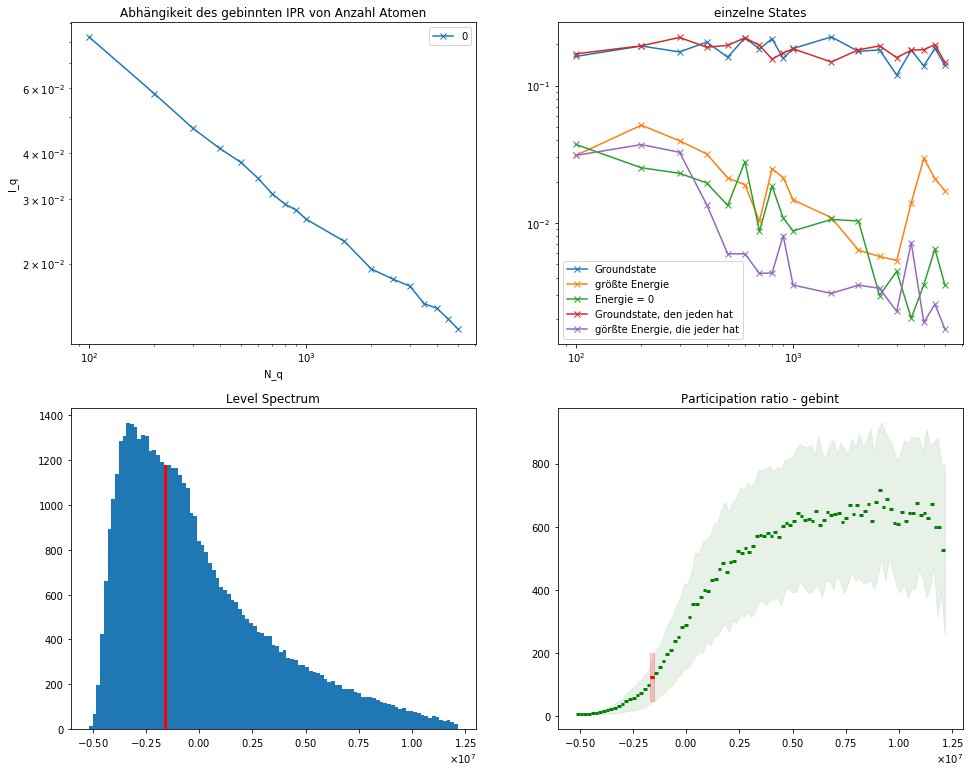

In [861]:
plot=20


fig, axes = plt.subplots(2,2, figsize=(16,13))
#axes.plot(states,fit(states,*popt));

axes[0,0].set_xscale("log")
axes[0,0].set_yscale("log")

x=np.arange(100,1000).astype(float)
#axes[0,0].plot(x,poly_func(1,x,-1))

#axes[0,0].set_ylim(0,1)
axes[0,0].set_title("Abhängikeit des gebinnten IPR von Anzahl Atomen")
axes[0,0].errorbar(anzahl,ipr_gebint[:,plot], marker="x",label="0")
#axes[0,0].fill_between(anzahl, ipr_gebint[:,plot]-ipr_std[:,plot], ipr_gebint[:,plot]+ipr_std[:,plot], color="darkseagreen", alpha=0.2)


axes[0,1].set_title("einzelne States")
axes[0,1].errorbar(anzahl,smallest_eig, marker="x",label="Groundstate")
axes[0,1].errorbar(anzahl,biggest_eig, marker="x",label="größte Energie")
axes[0,1].errorbar(anzahl,zero_eig, marker="x",label="Energie = 0 ")
axes[0,1].errorbar(anzahl,same_smallest_eig, marker="x",label="Groundstate, den jeden hat")
axes[0,1].errorbar(anzahl,same_biggest_eig, marker="x",label="görßte Energie, die jeder hat")

axes[0,1].set_xscale("log")
axes[0,1].set_yscale("log")

axes[0,1].legend()

axes[0,0].set_xlabel("N_q")
axes[0,0].set_ylabel("I_q")
axes[0,0].legend()


axes[1,0].set_title("Level Spectrum")
axes[1,0].hist(eigenvalues[-1],bins=bins)
binnss= np.linspace(bins[plot],bins[plot+1],2)
axes[1,0].hist(eigenvalues[-1],bins=binnss, color="red")
axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)



bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues[-1],1/ipr[-1], statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues[-1],1/ipr[-1], statistic='std', bins=bins)

axes[1,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
axes[1,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3)
axes[1,1].hlines(bin_means[plot],binnss[0],binnss[1], colors='red', lw=3)
axes[1,1].fill_between(binnss, bin_means[plot]-bin_std[plot], bin_means[plot]+bin_std[plot], color="red", alpha=0.2)
axes[1,1].set_title("Participation ratio - gebint")
axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)

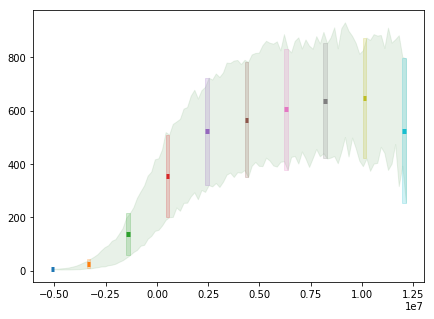

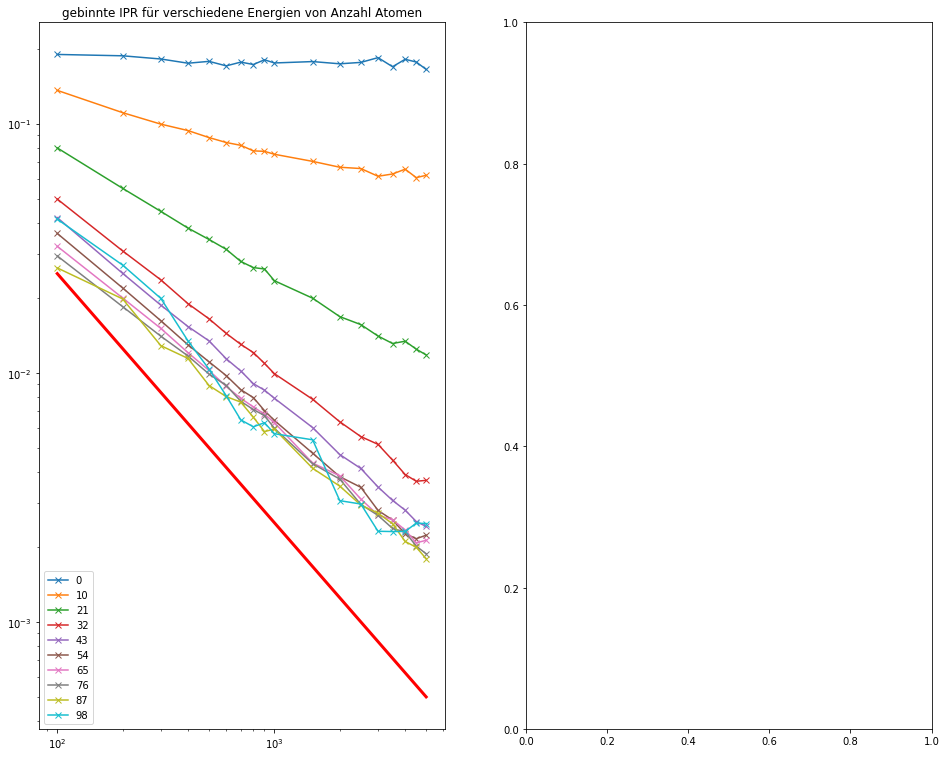

In [862]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

fig, axes = plt.subplots(1,1, figsize=(7,5))
#axes.plot(states,fit(states,*popt));
axes.fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
j=0
for i in np.linspace(0,steps-2,10).astype(int):
    binnss= np.linspace(bins[i],bins[i+1],2)
    axes.hlines(bin_means[i],binnss[0],binnss[1], lw=5, color=new_colors[j])
    axes.fill_between(binnss, bin_means[i]-bin_std[i], bin_means[i]+bin_std[i],color=new_colors[j], alpha=0.2)
    j+=1
    
fig, axes = plt.subplots(1,2, figsize=(16,13))
#axes.plot(states,fit(states,*popt));

axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("gebinnte IPR für verschiedene Energien von Anzahl Atomen")
x=np.arange(100,5000).astype(float)

axes[0].plot(x,poly_func([2.5,-1],x), color="red", linewidth="3")
#axes[0].set_ylim(0,1)


for i in np.linspace(0,steps-2,10).astype(int):
    axes[0].errorbar(anzahl,ipr_gebint[:,i], marker="x",label="%i"%i)
    
axes[0].legend()

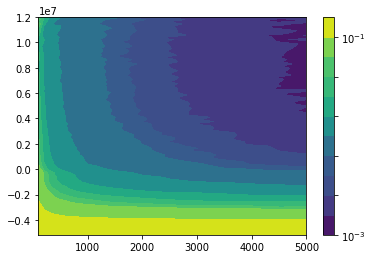

In [863]:
from matplotlib import ticker, cm
                 

plt.contourf(anzahl, bin_edges[:-1],(ipr_gebint.T),locator=ticker.LogLocator(base=10.0, subs=(1.0, 2,3,4,5)))
plt.colorbar()

In [864]:
frac_dimensions_odr=[]
frac_dimensions_scipy=[]

anzahl = anzahl.astype(float)

indices= np.arange(0,steps-1,1)


for plot in indices:
    poly = Model(poly_func)
    mydata = RealData(anzahl,ipr_gebint[:,plot],sy=ipr_std[:,plot])
    myodr= ODR(mydata,poly,beta0=[1,-1])
    myoutput = myodr.run()
    #myoutput.pprint()
    beta=myoutput.beta
    sd_beta=myoutput.sd_beta
    
    #popt,pcov = curve_fit(poly_func_scipy,anzahl,ipr_gebint[:,plot], p0=[1,-1])

    binnss= np.linspace(bins[plot],bins[plot+1],2)
    frac_odr= [binnss[0], binnss[1],beta[1],sd_beta[1]]
    frac_scipy= [binnss[0], binnss[1],popt[1], np.sqrt(pcov[1][1])]


    frac_dimensions_odr.append(frac_odr)
    frac_dimensions_scipy.append(frac_scipy)
    
frac_dimensions_odr = np.array(frac_dimensions_odr)
frac_dimensions_scipy = np.array(frac_dimensions_scipy)

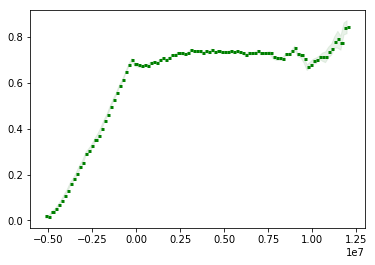

In [865]:
plt.fill_between(frac_dimensions_odr[:,0], (-frac_dimensions_odr[:,2])-frac_dimensions_odr[:,3], (-frac_dimensions_odr[:,2])+frac_dimensions_odr[:,3], color="darkseagreen", alpha=0.2)
plt.hlines(-frac_dimensions_odr[:,2], frac_dimensions_odr[:,0], frac_dimensions_odr[:,1], colors='g', lw=3);

#plt.hlines(-frac_dimensions_scipy[:,2], frac_dimensions_scipy[:,0], frac_dimensions_scipy[:,1], colors='r', lw=3)

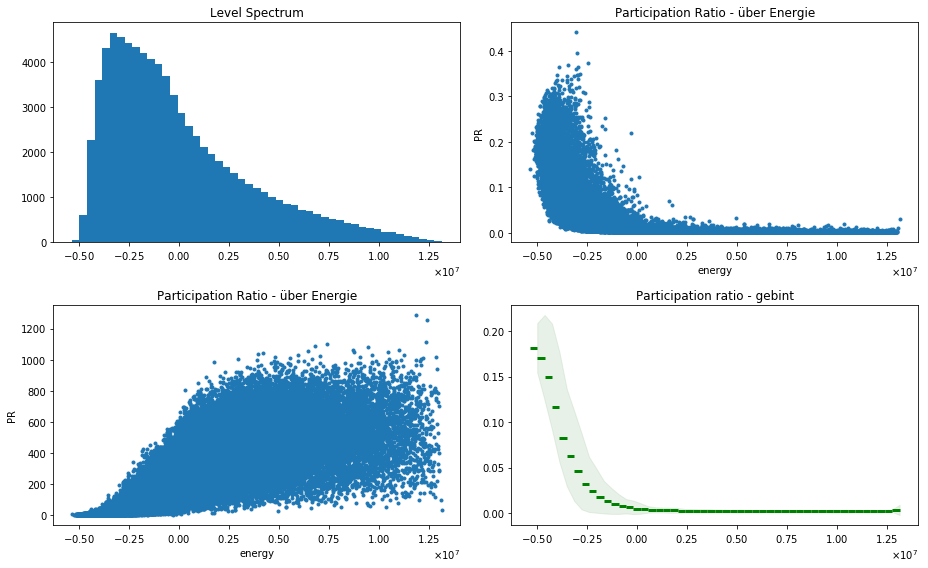

In [625]:
plot_all_eigenstates(ipr,ratios,15)

Aufgefallen:
Bei geringen Dichten, haben wir ne krasse Kante bei 0.5

In [227]:
def plot_all_eigenstates(ipr,ratio,plot):

    
    
    x=np.arange(0,radius,1)   
    
    fig, axes = plt.subplots(2,2,figsize=(13,8))  # 2 rows, 2 columns
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0.2)
    

   
    axes[0,0].set_title("Level Spectrum")
    bins = np.linspace(min(eigenvalues[plot]),max(eigenvalues[plot]),50)
    axes[0,0].hist(eigenvalues[plot],bins=bins)
    axes[0,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
    
    states=np.arange(0,anzahl[plot],1)
    axes[0,1].set_title("Participation Ratio - über Energie")
    axes[0,1].errorbar(eigenvalues[plot],ipr[plot], linestyle="None", marker=".") ;   
    #axes[1,0].set_yscale("log")
    axes[0,1].set_xlabel("energy")
    axes[0,1].set_ylabel("PR")
    axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
          
        
        
        
    states=np.arange(0,anzahl[plot],1)
    axes[1,0].set_title("Participation Ratio - über Energie")
    axes[1,0].errorbar(eigenvalues[plot],1/ipr[plot], linestyle="None", marker=".") ;   
    #axes[0,0].set_yscale("log")
    axes[1,0].set_xlabel("energy")
    axes[1,0].set_ylabel("PR")
    axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)   
        
        
        
    bin_means, bin_edges, binnumber = stats.binned_statistic(eigenvalues[plot],
                    ipr[plot], statistic='mean', bins=50)
    bin_std, bin_edges, binnumber = stats.binned_statistic(eigenvalues[plot],
                    ipr[plot], statistic='std', bins=50)
    
    
    axes[1,1].fill_between(bin_edges[1:], bin_means-bin_std, bin_means+bin_std, color="darkseagreen", alpha=0.2)
    axes[1,1].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3,
               label='binned statistic of data')
    axes[1,1].set_title("Participation ratio - gebint")
    axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(0,0),useMathText=True)
  
    

    fig.tight_layout()

In [29]:



k=0
ipr_all = np.zeros([number_atoms,18])
for j in range(number_atoms):
    k=0
    for i in np.arange(1,10,0.5):
        ipr_all[j][k]= (1/np.sum(p_eigenstates[:,j]**i))
        k+=1

return density_eig, n_eigenstate, correlation, ipr_2, ipr_all, schwerpunkt



"""
def fit (q,a):
    return 1000**(a*(q-1))


#popt,pcov = curve_fit(fit,states,ipr,p0=[1])
fig, axes = plt.subplots(1,2, figsize=(13,6))
#axes.plot(states,fit(states,*popt));

axes[0].set_xscale("log")
axes[0].set_yscale("log")
q=np.arange(1,10,0.5)
N_q= number_atoms**q
axes[0].errorbar(N_q,ipr_all[0], marker="x",label="0")
axes[0].errorbar(N_q,ipr_all[100], marker="x",label="100")
axes[0].errorbar(N_q,ipr_all[300], marker="x",label="300")
axes[0].errorbar(N_q,ipr_all[500], marker="x",label="500")
axes[0].errorbar(N_q,ipr_all[700], marker="x",label="700")
axes[0].set_xlabel("N_q")
axes[0].set_ylabel("I_q")
axes[0].legend()


popt,pcov = curve_fit(fit,q,ipr_all[900],p0=[0.8])


#axes[1].set_xscale("log")
axes[1].set_yscale("log")
q=np.arange(1,10,0.5)
N_q= number_atoms**q
axes[1].errorbar(q,ipr_all[0], marker="x")
axes[1].errorbar(q,ipr_all[100], marker="x")
axes[1].errorbar(q,ipr_all[300], marker="x")
axes[1].errorbar(q,ipr_all[500], marker="x")
axes[1].errorbar(q,ipr_all[700], marker="x")
axes[1].plot(q,fit(q,1), label="D=1")
axes[1].set_xlabel("q")
axes[1].set_ylabel("I_q")

popt,pcov = curve_fit(fit,q,ipr_all[900],p0=[0.8])
axes[1].plot(q,fit(q,*popt), label=("900:"+ r"$N^{D(q-1)}$" +"mit D=",round(popt[0],2)))

popt,pcov = curve_fit(fit,q,ipr_all[0],p0=[0.1])
axes[1].plot(q,fit(q,*popt), label=("0:"+ r"$N^{D(q-1)}$" +"mit D=",round(popt[0],2)))
axes[1].legend()



"""


SyntaxError: 'return' outside function (<ipython-input-29-eb120b853c08>, line 12)